旅行商问题（TSP）

  旅行商问题 TSP 是一个典型的组合优化问题，并且是一个 NP 完全问题，其可能 Hamilton 圈的数目是顶点的数目 n 的指数函数，所以一般很难精确地求出其最优解。所谓组合优化问题，是指在离散的，有限的数学结构上，寻找一个满足给定条件，并使其目标函数值达到最小或最大的解。一般来说，组合优化问题通常带有大量的局部极值点，通常是非线性的 NP 完全问题。其最先起源于一个旅行商要访问他所有的客户，要发现一条最短的路线。用用图论的术语来说，旅行商问题就是在赋权完全图上找一个权最小的 Hamilton 圈。但是，首先从应用上来说，很多实际应用问题，如印制电路板的、连锁店的货物配送路线等，经简化的处理后，均可转化为旅行商问题TSP。
 
选取 Hopfield 作为神经网络解决 TSP 问题的方法
 
  由于网络参数优化不够好，因此将城市数量减少到8个。结果不好的原因是建立 Hopfield 网络得到的解，不一定是最优解，可能是次优解，或是不可行解。一般神经网络（RBF或BP）是单项的，而 Hopfield 网络特点在于有反馈，而最终得到的结果是一个网络的收敛值。对于一个 Hopfield 网络来说，关键是在于确定它在稳定条件下的权系数，不断的改变权系数来逼近样本。

In [22]:
import numpy as np
from matplotlib import pyplot as plt

Hopfield神经网络有如下特点

（1）每个神经元既是输入也是输出，构成单层全连接递归网络

（2）网络的突触权值不同于其他的神经网络是通过有监督或无监督反复学习来获得，而是在搭建网络时就按照一定的规则计算出来，且网络的权值在整个网络迭代过程中不再改变

（3）网络的状态是随时间的变化而变化的，每个神经元在t时刻的输出状态和自己t-1时刻有关

（4）引入能量函数的概念，用来判断网络迭代的稳定性，即网络的收敛，就是指能量函数达到极小值

（5）网络的解，即是网络运行到稳定时，各个神经元的状态集合

TSP问题是组合优化，使用Hopfield神经网络的CHNN模型，将网络抽象为

（1）Hopfield神经网络等效为放大电子电路

（2）Hopfield每一个神经元等效为一个电子放大器元件

（3）Hopfield每一个神经元的输入和输出，等效为电子元件的输入电压和输出电压

（4）每一个电子元件（神经元）输出的电信号有正负值，正值代表兴奋，负值代表抑制

（5）每一个电子元件（神经元）的输入信息，包含恒定的外部电流输入，和其它电子元件的反馈连接

  将8个城市，通过构造NN模型，将每一个城市对应于神经网络的每一个神经元，即案例的TSP问题可以用8x8=64个神经元组成的Hopfield网络来求解

In [23]:
#get distance between cities
def get_distance(citys):
    N = len(citys)
    distance = np.zeros((N, N))
    for i, curr_point in enumerate(citys):
        line = []
        [line.append(price_cn(curr_point, other_point)) if i != j else line.append(0.0) for j, other_point in enumerate(citys)]
        distance[i] = line
    return distance

In [24]:
#calculate function du
def calc_du(V, distance):
    a = np.sum(V, axis=0) - 1  # 按列相加
    b = np.sum(V, axis=1) - 1  # 按行相加
    t1 = np.zeros((N, N))
    t2 = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            t1[i, j] = a[j]
    for i in range(N):
        for j in range(N):
            t2[j, i] = b[j]
    # 将第一列移动到最后一列
    c_1 = V[:, 1:N]
    c_0 = np.zeros((N, 1))
    c_0[:, 0] = V[:, 0]
    c = np.concatenate((c_1, c_0), axis=1)
    c = np.dot(distance, c)
    return -A * (t1 + t2) - D * c

In [25]:
#cost function
def price_cn(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))
def calc_distance(path):
    dis = 0.0
    for i in range(len(path) - 1):
        dis += distance[path[i]][path[i+1]]
    return dis

In [26]:
# renew input U
def calc_U(U, du, step):
    return U + du * step
# renew output V
def calc_V(U, U0):
    return 1 / 2 * (1 + np.tanh(U / U0))

In [27]:
# current energy
def calc_energy(V, distance):
    t1 = np.sum(np.power(np.sum(V, axis=0) - 1, 2))
    t2 = np.sum(np.power(np.sum(V, axis=1) - 1, 2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = distance * Vt
    t3 = np.sum(np.sum(np.multiply(V, t3)))
    e = 0.5 * (A * (t1 + t2) + D * t3)
    return e

In [28]:
#check path
def check_path(V):
    newV = np.zeros([N, N])
    route = []
    for i in range(N):
        mm = np.max(V[:, i])
        for j in range(N):
            if V[j, i] == mm:
                newV[j, i] = 1
                route += [j]
                break
    return route, newV

In [29]:
#visualization
def draw_H_and_E(citys, H_path, energys):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    for (from_, to_) in H_path:
        p1 = plt.Circle(citys[from_], 0.2, color='red')
        p2 = plt.Circle(citys[to_], 0.2, color='red')
        ax1.add_patch(p1)
        ax1.add_patch(p2)
        ax1.plot((citys[from_][0], citys[to_][0]), (citys[from_][1], citys[to_][1]), color='red')
        ax1.annotate(text=chr(97 + to_), xy=citys[to_], xytext=(-8, -4), textcoords='offset points', fontsize=20)
    ax1.axis('equal')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(0, len(energys), 1), energys, color='red')
    plt.show()

 设置TSP案例的参数

In [30]:
citys = np.array([ [3, 5], [4, 4], [6, 4], [3, 2],[2, 6], [2, 4], [1, 3], [4, 6]])
distance = get_distance(citys)
N = len(citys)
A = N * N
D = N / 2
U0 = 0.0009  
step = 0.0001 
num_iter = 10000  
# input U
U = 1 / 2 * U0 * np.log(N - 1) + (2 * (np.random.random((N, N))) - 1)
# output V
V = calc_V(U, U0)
energys = np.array([0.0 for x in range(num_iter)]) 
best_distance = np.inf  
best_route = []  
H_path = []  

iter 116 distance:21.741114189575445, energy:211.48641739582226, path:
e,a,f,c,d,g,h,b,e
iter 187 distance:20.006732637524404, energy:190.25352655284453, path:
e,a,c,h,d,g,f,b,e
iter 221 distance:18.948122114152724, energy:103.33879759192202, path:
e,a,c,h,f,g,d,b,e
iter 895 distance:17.741114189575445, energy:514.627336513505, path:
b,a,h,c,d,g,f,e,b
iter 4576 distance:17.186912597118443, energy:276.2619746534866, path:
b,d,g,f,a,h,e,c,b
iter 7272 distance:16.912687064829253, energy:1093.3475621125417, path:
d,g,f,a,h,e,b,c,d
iter 8847 distance:16.46284073991415, energy:96.78405547337147, path:
g,f,e,h,a,c,b,d,g


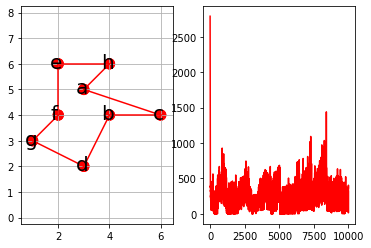

In [31]:
for n in range(num_iter):
    du = calc_du(V, distance)
    U = calc_U(U, du, step)
    V = calc_V(U, U0)
    energys[n] = calc_energy(V, distance)
    route, newV = check_path(V)
    if len(np.unique(route)) == N:
        route.append(route[0])
        dis = calc_distance(route)
        if dis < best_distance:
            H_path = []
            best_distance = dis
            best_route = route
            [H_path.append((route[i], route[i + 1])) for i in range(len(route) - 1)]
            print('iter {} distance:{}, energy:{}, path:'.format(n, best_distance, energys[n]))
            [print(chr(97 + v), end=',' if i < len(best_route) - 1 else '\n') for i, v in enumerate(best_route)]
if len(H_path) > 0:
    draw_H_and_E(citys, H_path, energys)
else:
    print('没有找到最优解')

由上图所示，左图为最终Hopfield神经网络找到的最优哈密顿回路，右图为在神经网络优化过程中能量函数的波动，在初值设置得当的情况下，Hopfield神经网络找到的最优解与真实最优解一致。